# Convolutional Neural Network (CNN)

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html).


### Import PyTorch

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [4]:
from torchvision import datasets
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
db_train = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
db_test = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)
def subsample(db, n):
    idx = np.random.permutation(len(db))[:n]
    db.data = db.data[idx]
    db.targets = np.array(db.targets)[idx]
    return db

db_train = subsample(db_train, 5000)
db_test = subsample(db_test, 1000)

img, y = db_train[0]
print(img.shape, img.min(), img.max(), y)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) tensor(0.0353) tensor(0.9804) 4


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.
Note that transforms.ToTensor transformed our image 32x32x3 image into a 3x32x32 tensor (the format that Conv2d layers expect). 
However, to display the image, we need to permute its dimensions again.


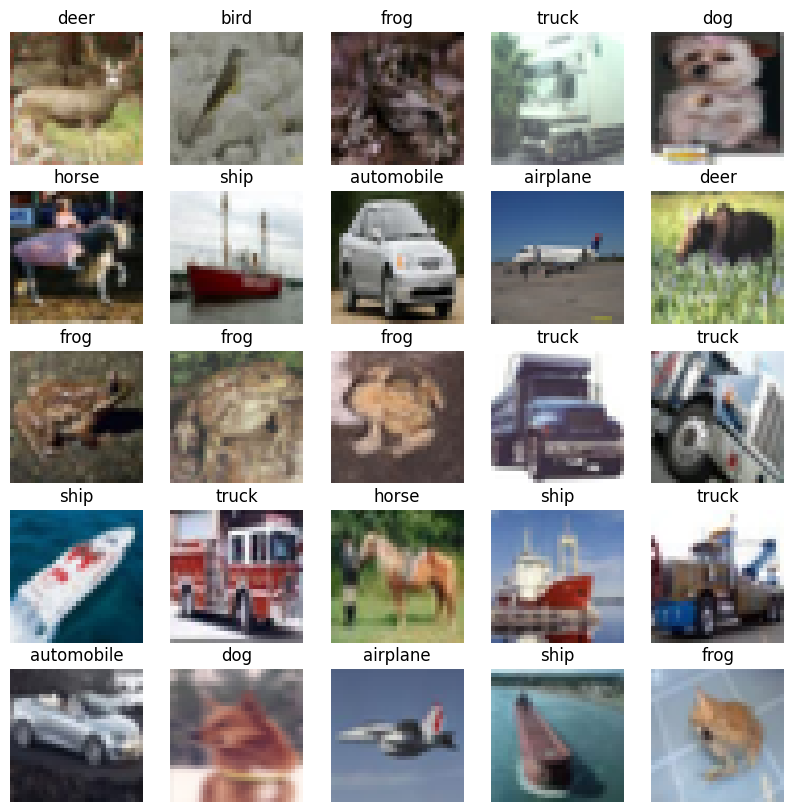

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    img, lbl = db_train[i]
    plt.subplot(5,5,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[lbl])
    plt.axis(False)
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [6]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1024, 10)
)

Here's the complete architecture of your model:

In [7]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1024, out_features=10, bias=True)
)


### Train the model

In [8]:
from torch.utils.data import DataLoader
import tqdm

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0, std=0.005)

def accuracy(pred, labels):
    return (pred.argmax(-1) == labels).float().mean()


@torch.no_grad()
def eval(model, loader):
    accuracies = []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        acc = accuracy(pred, labels)
        accuracies.append(acc.detach().item())
    return np.mean(accuracies)

def fit_one_epoch(model, opt, loader):
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        l = loss(pred, labels)
        acc = accuracy(pred, labels)

        # Compute gradients and update the model
        opt.zero_grad()
        l.backward()
        opt.step()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_test, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    hist_tr_loss, hist_tr_acc, hist_te_acc = [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        te_acc = eval(model, loader_test)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}   Train Acc = {tr_acc:.3f}   Test Acc = {te_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_tr_acc.append(tr_acc)
        hist_te_acc.append(te_acc)
    return hist_tr_loss, hist_tr_acc, hist_te_acc

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
model = model.to(device)
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 63.10it/s]

Finished epoch 0 of 30: Train Loss = 2.271   Train Acc = 0.122   Test Acc = 0.214



100%|██████████| 16/16 [00:00<00:00, 63.00it/s]

Finished epoch 1 of 30: Train Loss = 2.097   Train Acc = 0.203   Test Acc = 0.212



100%|██████████| 16/16 [00:00<00:00, 70.26it/s]

Finished epoch 2 of 30: Train Loss = 2.050   Train Acc = 0.226   Test Acc = 0.259



100%|██████████| 16/16 [00:00<00:00, 53.69it/s]

Finished epoch 3 of 30: Train Loss = 2.022   Train Acc = 0.248   Test Acc = 0.250



100%|██████████| 16/16 [00:00<00:00, 59.35it/s]

Finished epoch 4 of 30: Train Loss = 1.994   Train Acc = 0.263   Test Acc = 0.268



100%|██████████| 16/16 [00:00<00:00, 64.84it/s]

Finished epoch 5 of 30: Train Loss = 1.986   Train Acc = 0.273   Test Acc = 0.283



100%|██████████| 16/16 [00:00<00:00, 71.45it/s]

Finished epoch 6 of 30: Train Loss = 1.958   Train Acc = 0.278   Test Acc = 0.283



100%|██████████| 16/16 [00:00<00:00, 66.72it/s]

Finished epoch 7 of 30: Train Loss = 1.945   Train Acc = 0.283   Test Acc = 0.275



100%|██████████| 16/16 [00:00<00:00, 61.64it/s]

Finished epoch 8 of 30: Train Loss = 1.925   Train Acc = 0.297   Test Acc = 0.313



100%|██████████| 16/16 [00:00<00:00, 66.82it/s]

Finished epoch 9 of 30: Train Loss = 1.905   Train Acc = 0.307   Test Acc = 0.298



100%|██████████| 16/16 [00:00<00:00, 66.64it/s]

Finished epoch 10 of 30: Train Loss = 1.885   Train Acc = 0.316   Test Acc = 0.322



100%|██████████| 16/16 [00:00<00:00, 62.75it/s]

Finished epoch 11 of 30: Train Loss = 1.862   Train Acc = 0.327   Test Acc = 0.319



100%|██████████| 16/16 [00:00<00:00, 68.12it/s]

Finished epoch 12 of 30: Train Loss = 1.842   Train Acc = 0.335   Test Acc = 0.332



100%|██████████| 16/16 [00:00<00:00, 69.30it/s]

Finished epoch 13 of 30: Train Loss = 1.816   Train Acc = 0.342   Test Acc = 0.322



100%|██████████| 16/16 [00:00<00:00, 58.18it/s]

Finished epoch 14 of 30: Train Loss = 1.795   Train Acc = 0.356   Test Acc = 0.349



100%|██████████| 16/16 [00:00<00:00, 60.14it/s]

Finished epoch 15 of 30: Train Loss = 1.768   Train Acc = 0.360   Test Acc = 0.371



100%|██████████| 16/16 [00:00<00:00, 62.18it/s]

Finished epoch 16 of 30: Train Loss = 1.734   Train Acc = 0.383   Test Acc = 0.358



100%|██████████| 16/16 [00:00<00:00, 58.71it/s]

Finished epoch 17 of 30: Train Loss = 1.713   Train Acc = 0.387   Test Acc = 0.381



100%|██████████| 16/16 [00:00<00:00, 53.17it/s]

Finished epoch 18 of 30: Train Loss = 1.689   Train Acc = 0.400   Test Acc = 0.389



100%|██████████| 16/16 [00:00<00:00, 50.33it/s]

Finished epoch 19 of 30: Train Loss = 1.647   Train Acc = 0.413   Test Acc = 0.415



100%|██████████| 16/16 [00:00<00:00, 59.39it/s]

Finished epoch 20 of 30: Train Loss = 1.623   Train Acc = 0.425   Test Acc = 0.413



100%|██████████| 16/16 [00:00<00:00, 64.03it/s]

Finished epoch 21 of 30: Train Loss = 1.595   Train Acc = 0.433   Test Acc = 0.428



100%|██████████| 16/16 [00:00<00:00, 55.49it/s]

Finished epoch 22 of 30: Train Loss = 1.578   Train Acc = 0.436   Test Acc = 0.414



100%|██████████| 16/16 [00:00<00:00, 61.47it/s]

Finished epoch 23 of 30: Train Loss = 1.552   Train Acc = 0.448   Test Acc = 0.436



100%|██████████| 16/16 [00:00<00:00, 62.07it/s]

Finished epoch 24 of 30: Train Loss = 1.537   Train Acc = 0.460   Test Acc = 0.440



100%|██████████| 16/16 [00:00<00:00, 47.92it/s]

Finished epoch 25 of 30: Train Loss = 1.514   Train Acc = 0.457   Test Acc = 0.452



100%|██████████| 16/16 [00:00<00:00, 57.60it/s]

Finished epoch 26 of 30: Train Loss = 1.499   Train Acc = 0.464   Test Acc = 0.440



100%|██████████| 16/16 [00:00<00:00, 54.38it/s]

Finished epoch 27 of 30: Train Loss = 1.484   Train Acc = 0.474   Test Acc = 0.446



100%|██████████| 16/16 [00:00<00:00, 65.97it/s]

Finished epoch 28 of 30: Train Loss = 1.468   Train Acc = 0.473   Test Acc = 0.437



100%|██████████| 16/16 [00:00<00:00, 45.78it/s]

Finished epoch 29 of 30: Train Loss = 1.460   Train Acc = 0.476   Test Acc = 0.424


### Evaluate the model

100%|██████████| 16/16 [00:00<00:00, 36.21it/s]


Test accuracy: 42.36%


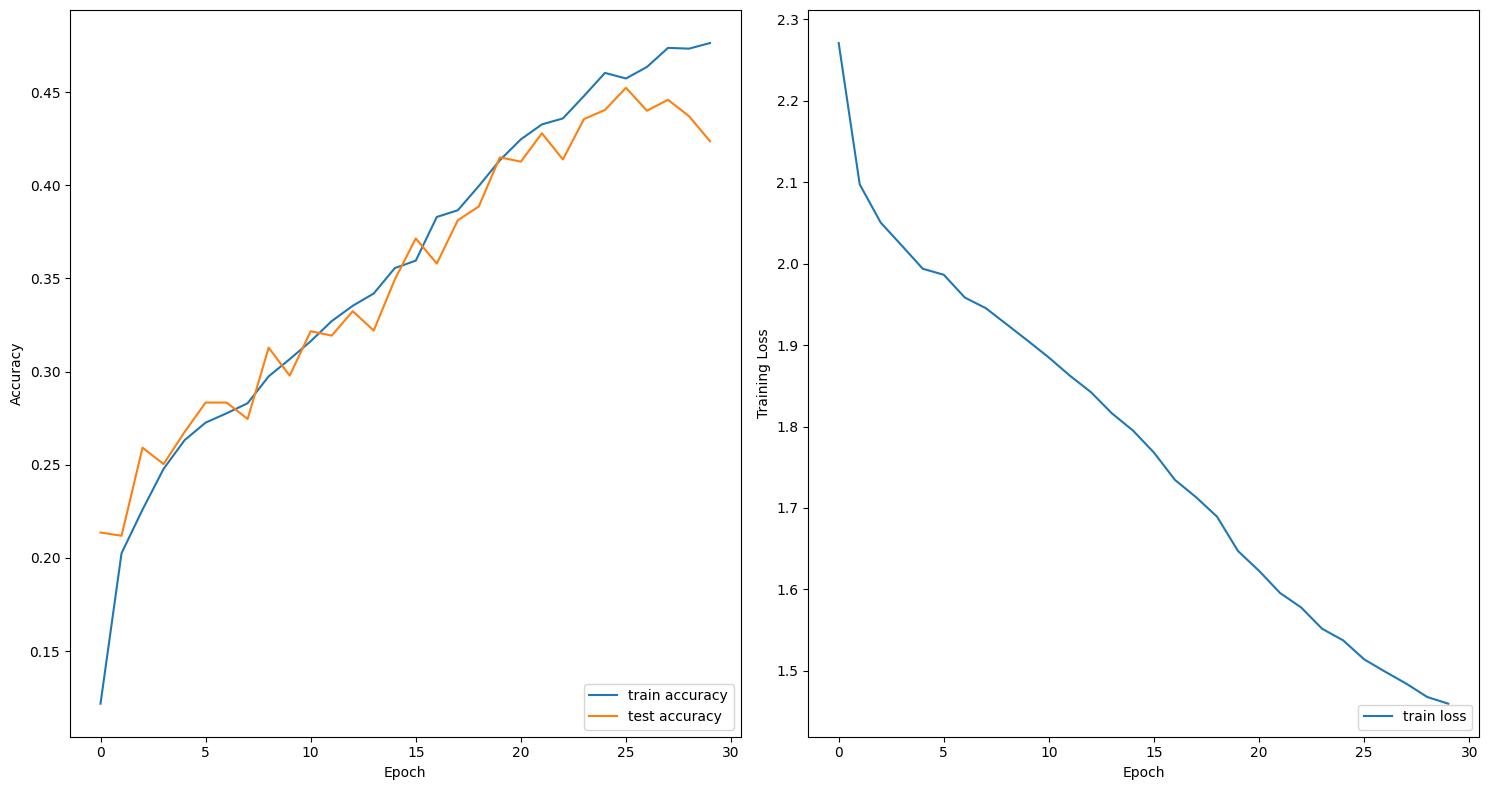

In [9]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

Now lets display a bunch of predictions of the model

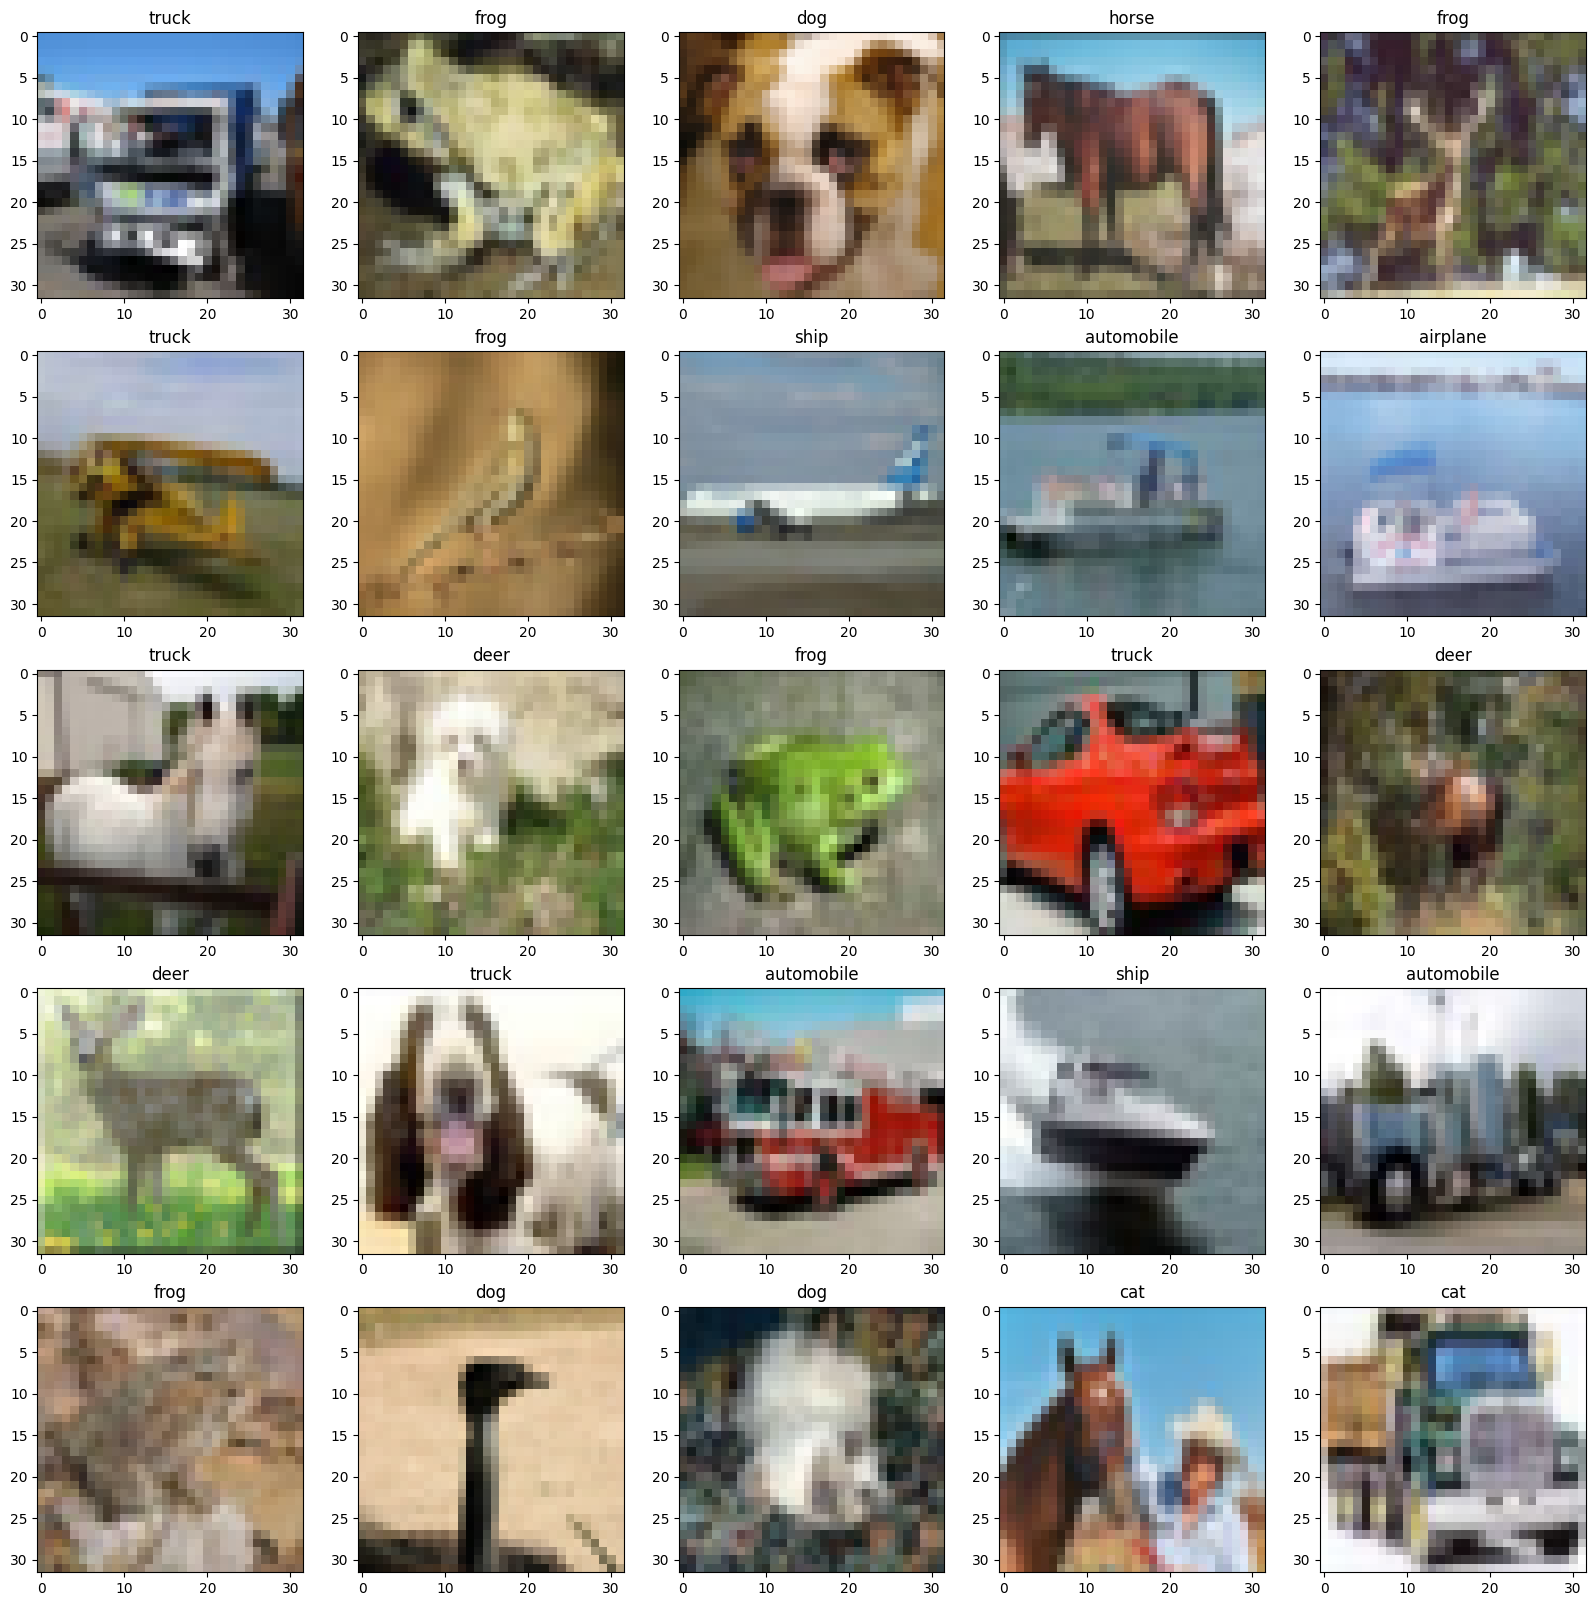

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
model = model.to(device)

plt.figure(figsize=(20,20))
for imgs, lbl in loader_test:
    with torch.no_grad():
        imgs = imgs.to(device)
        preds = model(imgs)
        preds = preds.argmax(1)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(imgs[i].cpu().permute(1, 2, 0))
        plt.title(class_names[preds[i]])
        # plt.axis(False)
plt.show()

# Batch Normalization
Typically, you would use PyTorch batch normalization class ([torch.nn.BatchNorm2D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)). However to gain an understanding of how batch norm works, we will implement our own. Complete the forward method of the MyBatchNorm class below. Recall that a batch norm layer performs two steps.
1. Normalizes the input x, by subtracting the mean and dividing by the standard deviation along the batch (ie along axis=0).
2. Outputs an affine transformation of the scaled input, i.e., x_out = alpha * x_norm + beta, where alpha and beta are trainable parameters of the model.

In [11]:
class MyBatchNorm(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(1, dims, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, dims, 1, 1))

    def forward(self, x):
        x_norm = ...
        x_out =  ...
        return x_out

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    MyBatchNorm(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    MyBatchNorm(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    MyBatchNorm(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1024, 10)
)

# Check the model
dummy_image = torch.randn(1, 3, 32, 32)
dummy_output = model(dummy_image)
print(f"{str(dummy_image.shape)} -> {str(dummy_output.shape)}")

TypeError: relu(): argument 'input' (position 1) must be Tensor, not ellipsis

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.98it/s]

Finished epoch 0 of 30: Train Loss = 1.771   Train Acc = 0.353   Test Acc = 0.434



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.37it/s]

Finished epoch 1 of 30: Train Loss = 1.430   Train Acc = 0.489   Test Acc = 0.463



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.44it/s]

Finished epoch 2 of 30: Train Loss = 1.270   Train Acc = 0.547   Test Acc = 0.496



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.76it/s]

Finished epoch 3 of 30: Train Loss = 1.139   Train Acc = 0.596   Test Acc = 0.548



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.13it/s]

Finished epoch 4 of 30: Train Loss = 1.035   Train Acc = 0.640   Test Acc = 0.528



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.52it/s]

Finished epoch 5 of 30: Train Loss = 0.952   Train Acc = 0.671   Test Acc = 0.561



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.22it/s]

Finished epoch 6 of 30: Train Loss = 0.863   Train Acc = 0.709   Test Acc = 0.562



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.49it/s]

Finished epoch 7 of 30: Train Loss = 0.789   Train Acc = 0.733   Test Acc = 0.562



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.91it/s]

Finished epoch 8 of 30: Train Loss = 0.723   Train Acc = 0.760   Test Acc = 0.577



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 29.93it/s]

Finished epoch 9 of 30: Train Loss = 0.657   Train Acc = 0.779   Test Acc = 0.587



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.18it/s]

Finished epoch 10 of 30: Train Loss = 0.576   Train Acc = 0.818   Test Acc = 0.602



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.92it/s]

Finished epoch 11 of 30: Train Loss = 0.517   Train Acc = 0.843   Test Acc = 0.581



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.38it/s]

Finished epoch 12 of 30: Train Loss = 0.467   Train Acc = 0.857   Test Acc = 0.580



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.41it/s]

Finished epoch 13 of 30: Train Loss = 0.406   Train Acc = 0.878   Test Acc = 0.583



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.52it/s]

Finished epoch 14 of 30: Train Loss = 0.351   Train Acc = 0.902   Test Acc = 0.577



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.79it/s]

Finished epoch 15 of 30: Train Loss = 0.297   Train Acc = 0.924   Test Acc = 0.598



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.27it/s]

Finished epoch 16 of 30: Train Loss = 0.255   Train Acc = 0.940   Test Acc = 0.597



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.81it/s]

Finished epoch 17 of 30: Train Loss = 0.219   Train Acc = 0.954   Test Acc = 0.579



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 29.45it/s]

Finished epoch 18 of 30: Train Loss = 0.196   Train Acc = 0.962   Test Acc = 0.573



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.77it/s]

Finished epoch 19 of 30: Train Loss = 0.164   Train Acc = 0.971   Test Acc = 0.576



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.55it/s]

Finished epoch 20 of 30: Train Loss = 0.144   Train Acc = 0.974   Test Acc = 0.602



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 29.70it/s]

Finished epoch 21 of 30: Train Loss = 0.108   Train Acc = 0.986   Test Acc = 0.604



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.78it/s]

Finished epoch 22 of 30: Train Loss = 0.084   Train Acc = 0.993   Test Acc = 0.603



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.95it/s]

Finished epoch 23 of 30: Train Loss = 0.068   Train Acc = 0.994   Test Acc = 0.598



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 28.80it/s]

Finished epoch 24 of 30: Train Loss = 0.066   Train Acc = 0.994   Test Acc = 0.597



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 33.05it/s]

Finished epoch 25 of 30: Train Loss = 0.055   Train Acc = 0.998   Test Acc = 0.602



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.37it/s]

Finished epoch 26 of 30: Train Loss = 0.048   Train Acc = 0.997   Test Acc = 0.599



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.72it/s]

Finished epoch 27 of 30: Train Loss = 0.040   Train Acc = 0.998   Test Acc = 0.625



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.60it/s]

Finished epoch 28 of 30: Train Loss = 0.029   Train Acc = 1.000   Test Acc = 0.622



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.60it/s]

Finished epoch 29 of 30: Train Loss = 0.026   Train Acc = 0.999   Test Acc = 0.615



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.22it/s]


Test accuracy: 0.6146484389901161


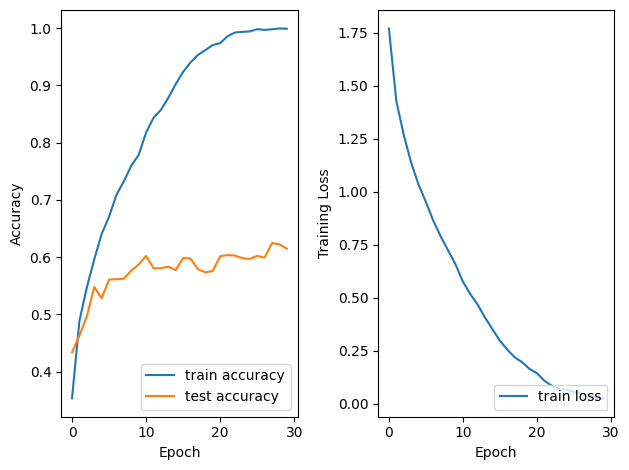

In [ ]:
# Train the model
init_weights(model)
model = model.to(device)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.3, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

# Evaluate
acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

# Data augmentations
Lets now try some data augmentations. The following code vizualizes four different types of data augmentations. What do each of them do?

Transform 1


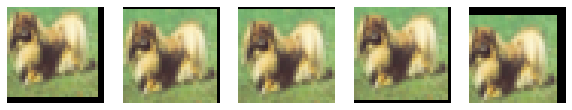

Transform 2


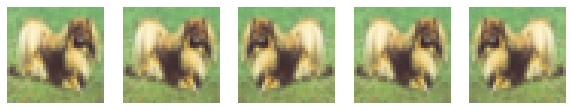

Transform 3


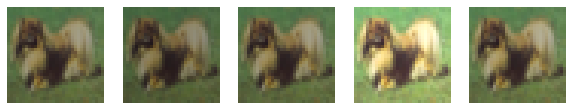

Transform 4


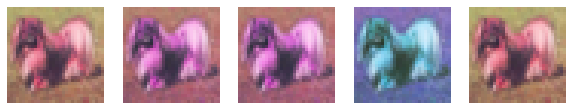

In [ ]:
def display_transform(transform, image_idx=10):
    # The CIFAR dataset uses db.transform to transform each image.
    # We can change the data augmentation by assigning our new transformation to this variable.
    # See __getitem__ in https://pytorch.org/vision/stable/_modules/torchvision/datasets/cifar.html#CIFAR10 for how db.transform is used.
    db_train.transform = transform
    plt.figure(figsize=(20,6))
    for i in range(5):
        img, lbl = db_train[image_idx]
        plt.subplot(1,5,1+i)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis(False)
    plt.show()

print("Transform 1")
transform1 = transforms.Compose([
    transforms.RandomCrop(size=[32,32], padding=3),
    transforms.ToTensor()
])
display_transform(transform1, image_idx=0)

print("Transform 2")
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])
display_transform(transform2, image_idx=0)

print("Transform 3")
transform3 = transforms.Compose([
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor()
])
display_transform(transform3, image_idx=0)

print("Transform 4")
transform4 = transforms.Compose([
    transforms.ColorJitter(hue=0.5),
    transforms.ToTensor()
])
display_transform(transform4, image_idx=0)

Lets now train a new model (with batch normalization) using data augmentations. Speficially we will augment our images in two ways. 1) Random crops by first padding the images on all sides with zeros followed by a random crop and 2) by randomly flipping the image with a 50% probability.

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.42it/s]

Finished epoch 0 of 30: Train Loss = 1.771   Train Acc = 0.347   Test Acc = 0.436



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.57it/s]

Finished epoch 1 of 30: Train Loss = 1.521   Train Acc = 0.442   Test Acc = 0.448



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 33.21it/s]

Finished epoch 2 of 30: Train Loss = 1.410   Train Acc = 0.498   Test Acc = 0.491



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.53it/s]

Finished epoch 3 of 30: Train Loss = 1.325   Train Acc = 0.524   Test Acc = 0.507



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.46it/s]

Finished epoch 4 of 30: Train Loss = 1.248   Train Acc = 0.548   Test Acc = 0.560



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.46it/s]

Finished epoch 5 of 30: Train Loss = 1.189   Train Acc = 0.574   Test Acc = 0.538



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.10it/s]

Finished epoch 6 of 30: Train Loss = 1.134   Train Acc = 0.586   Test Acc = 0.559



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.42it/s]

Finished epoch 7 of 30: Train Loss = 1.123   Train Acc = 0.601   Test Acc = 0.587



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 29.73it/s]

Finished epoch 8 of 30: Train Loss = 1.065   Train Acc = 0.617   Test Acc = 0.602



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.57it/s]

Finished epoch 9 of 30: Train Loss = 1.048   Train Acc = 0.626   Test Acc = 0.599



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 33.08it/s]

Finished epoch 10 of 30: Train Loss = 0.988   Train Acc = 0.653   Test Acc = 0.623



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.87it/s]

Finished epoch 11 of 30: Train Loss = 0.986   Train Acc = 0.652   Test Acc = 0.626



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.03it/s]

Finished epoch 12 of 30: Train Loss = 0.962   Train Acc = 0.658   Test Acc = 0.621



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.02it/s]

Finished epoch 13 of 30: Train Loss = 0.944   Train Acc = 0.665   Test Acc = 0.622



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.95it/s]

Finished epoch 14 of 30: Train Loss = 0.902   Train Acc = 0.684   Test Acc = 0.622



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.22it/s]

Finished epoch 15 of 30: Train Loss = 0.863   Train Acc = 0.698   Test Acc = 0.637



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 33.22it/s]

Finished epoch 16 of 30: Train Loss = 0.869   Train Acc = 0.694   Test Acc = 0.650



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.20it/s]

Finished epoch 17 of 30: Train Loss = 0.841   Train Acc = 0.706   Test Acc = 0.649



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.87it/s]

Finished epoch 18 of 30: Train Loss = 0.845   Train Acc = 0.705   Test Acc = 0.629



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.16it/s]

Finished epoch 19 of 30: Train Loss = 0.795   Train Acc = 0.718   Test Acc = 0.634



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.86it/s]

Finished epoch 20 of 30: Train Loss = 0.783   Train Acc = 0.733   Test Acc = 0.636



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.71it/s]

Finished epoch 21 of 30: Train Loss = 0.777   Train Acc = 0.733   Test Acc = 0.658



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.33it/s]

Finished epoch 22 of 30: Train Loss = 0.781   Train Acc = 0.721   Test Acc = 0.654



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.96it/s]

Finished epoch 23 of 30: Train Loss = 0.761   Train Acc = 0.735   Test Acc = 0.635



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.98it/s]

Finished epoch 24 of 30: Train Loss = 0.751   Train Acc = 0.733   Test Acc = 0.666



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 30.44it/s]

Finished epoch 25 of 30: Train Loss = 0.719   Train Acc = 0.751   Test Acc = 0.653



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.10it/s]

Finished epoch 26 of 30: Train Loss = 0.701   Train Acc = 0.756   Test Acc = 0.657



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.11it/s]

Finished epoch 27 of 30: Train Loss = 0.701   Train Acc = 0.749   Test Acc = 0.649



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 32.60it/s]

Finished epoch 28 of 30: Train Loss = 0.681   Train Acc = 0.754   Test Acc = 0.673



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.43it/s]

Finished epoch 29 of 30: Train Loss = 0.680   Train Acc = 0.761   Test Acc = 0.656



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 31.76it/s]


Test accuracy: 65.59%


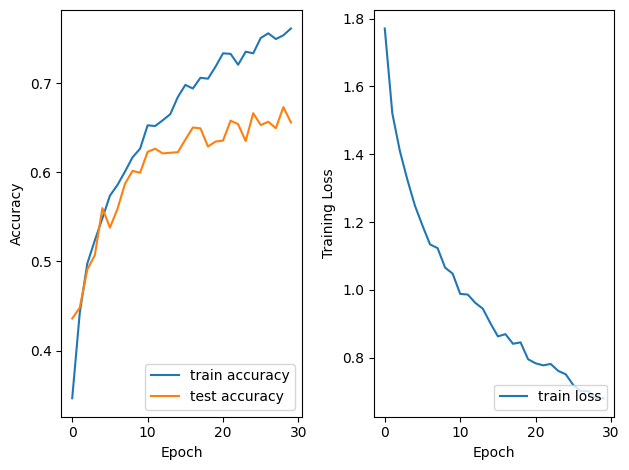

In [ ]:
# Define new transform
db_train.transform = transforms.Compose([
    ???
    transforms.ToTensor()
])

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.3, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

# Evaluate
acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')